# This Notebook will investigate the absolute number of times that a sensor has a measure outside of the acceptable boundaries.
- RS_E_InAirTemp: boundary 65 degrees
- RS_E_OilPress: boundary 115 degrees
- RS_E_WatTemp: boundary 100 degrees

In [67]:
# Python standard library imports
import time

# Third-party imports for database connection and data manipulation
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
# Third-party imports for mapping
import folium

Section 2: Connection

In [34]:
# Database connection parameters
dbname = 'DataMining'
user = 'postgres'
password = 'datamining'
host = 'localhost'  # localhost or the server address
port = '5433'  # default PostgreSQL port is 5432
vehicle_id = 181  # Replace with the vehicle ID you are interested in

# Establish a connection to the database
connection_str = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"
engine = create_engine(connection_str)

Section 3: Define and Execute Query

In [39]:
# Define the query with placeholders for parameters
query_air = f"""
SELECT mapped_veh_id, COUNT(*) as occurrence_count
FROM vehicle_data
WHERE rs_e_inairtemp_pc1 > 65 OR rs_e_inairtemp_pc2 > 65
GROUP BY mapped_veh_id
ORDER BY occurrence_count;
"""

In [40]:
# Define the query with placeholders for parameters
query_oil = f"""
SELECT mapped_veh_id, COUNT(*) as occurrence_count
FROM vehicle_data
WHERE rs_e_oilpress_pc1 > 115 OR rs_e_oilpress_pc2 > 115
GROUP BY mapped_veh_id
ORDER BY occurrence_count;
"""

In [43]:
# Define the query with placeholders for parameters
query_water = f"""
SELECT mapped_veh_id, COUNT(*) as occurrence_count
FROM vehicle_data
WHERE rs_e_wattemp_pc1 > 100 OR rs_e_wattemp_pc2 > 100
GROUP BY mapped_veh_id
ORDER BY occurrence_count;
"""

In [44]:
# Execute the query and fetch the data into a DataFrame
df_air = pd.read_sql_query(query_air, engine)
df_oil = pd.read_sql_query(query_oil, engine)
df_water = pd.read_sql_query(query_water, engine)

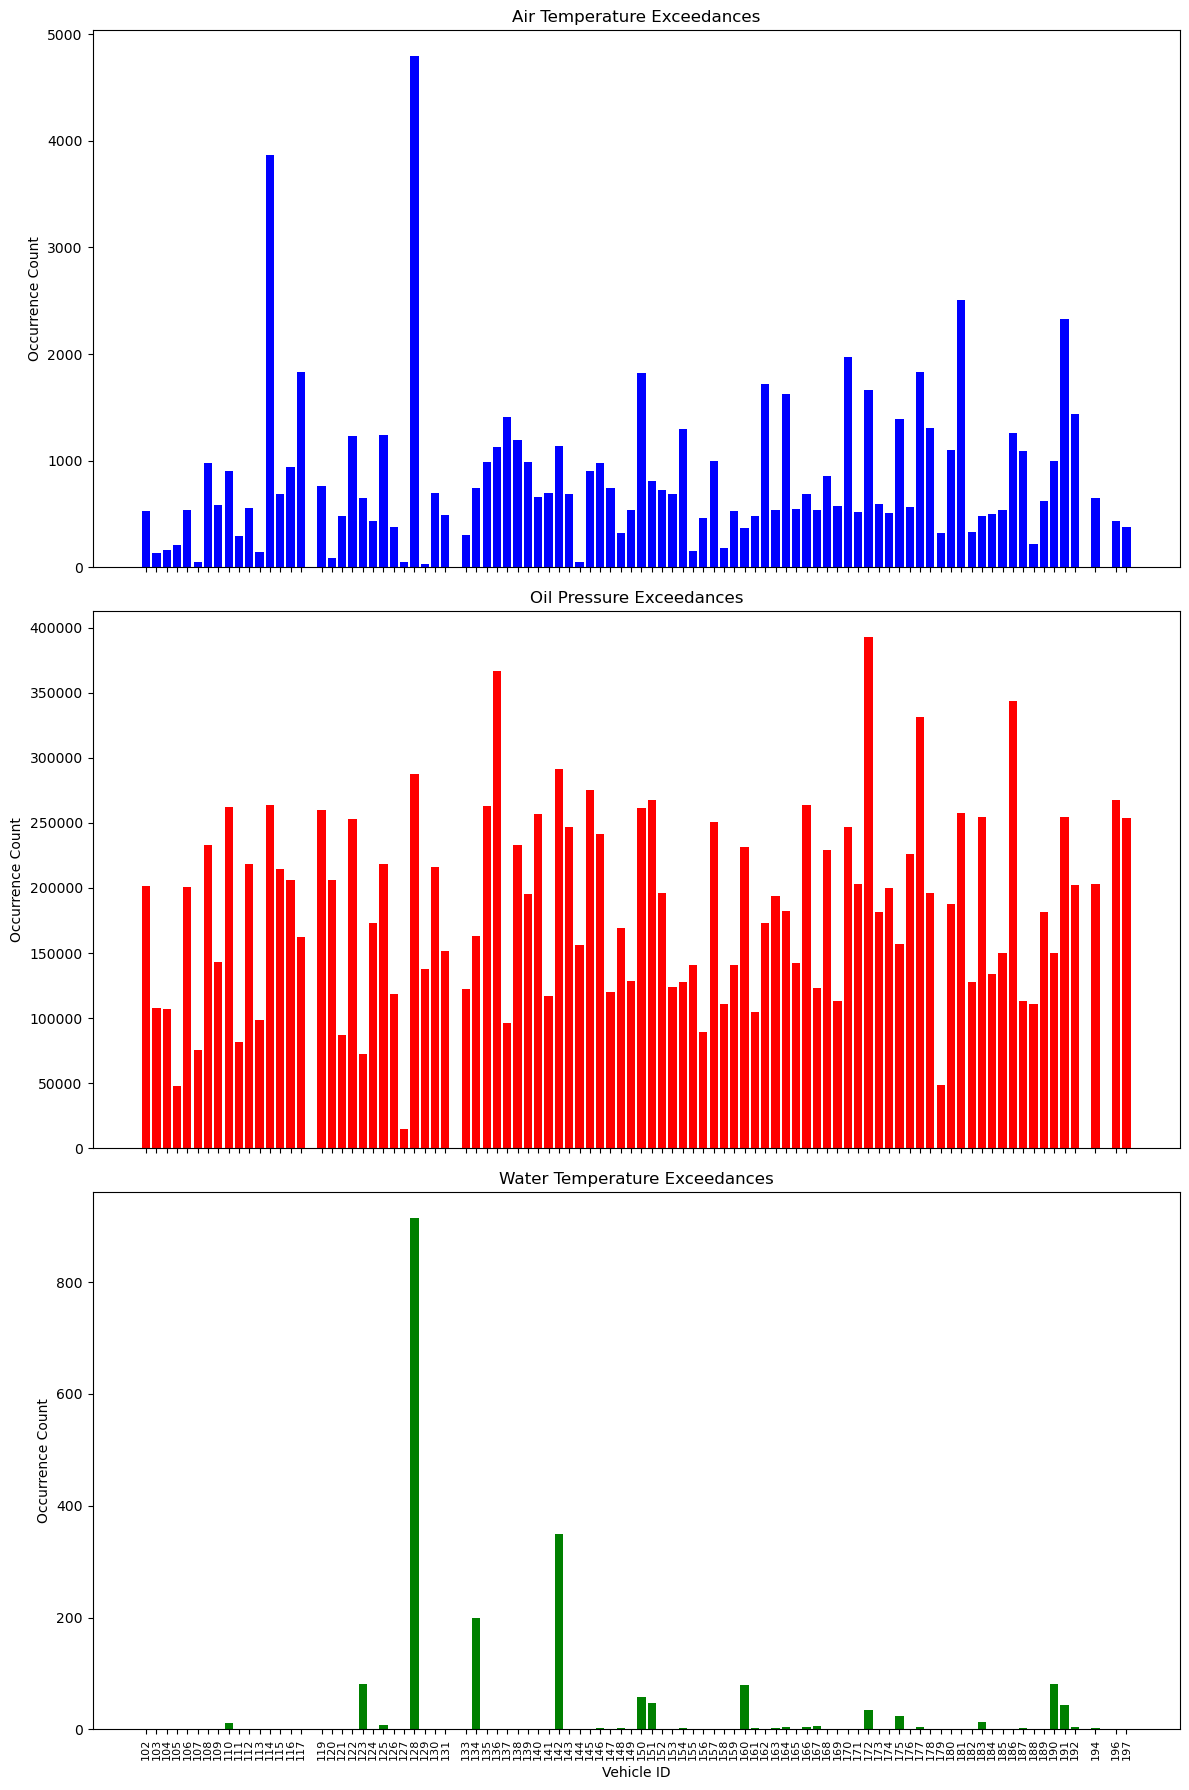

In [65]:
# Adjusting the charts to share the x-axis (Vehicle IDs) for better visibility and comparison

# Creating a list of all unique vehicle IDs from the three dataframes
all_vehicle_ids = sorted(set(df_air['mapped_veh_id']) | set(df_oil['mapped_veh_id']) | set(df_water['mapped_veh_id']))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18), sharex=True)  # Sharing the x-axis

# Air Temperature Exceedances
axes[0].bar(df_air['mapped_veh_id'], df_air['occurrence_count'], color='blue')
axes[0].set_title('Air Temperature Exceedances')
axes[0].set_ylabel('Occurrence Count')
axes[0].set_xticks(all_vehicle_ids)
axes[0].set_xticklabels(all_vehicle_ids, rotation=90, fontsize=8)  # Rotate and set font size

# Oil Pressure Exceedances
axes[1].bar(df_oil['mapped_veh_id'], df_oil['occurrence_count'], color='red')
axes[1].set_title('Oil Pressure Exceedances')
axes[1].set_ylabel('Occurrence Count')
axes[1].set_xticks(all_vehicle_ids)
axes[1].set_xticklabels(all_vehicle_ids, rotation=90, fontsize=8)  # Rotate and set font size

# Water Temperature Exceedances
axes[2].bar(df_water['mapped_veh_id'], df_water['occurrence_count'], color='green')
axes[2].set_title('Water Temperature Exceedances')
axes[2].set_xlabel('Vehicle ID')
axes[2].set_ylabel('Occurrence Count')
axes[2].set_xticks(all_vehicle_ids)
axes[2].set_xticklabels(all_vehicle_ids, rotation=90, fontsize=8)  # Rotate and set font size

plt.tight_layout()
plt.show()

# Graph Analysis

## Overview
The provided graph displays three different sets of exceedance data: air temperature, oil pressure, and water temperature, each represented by a different color (blue, red, and green respectively).

## Air Temperature Exceedances
- Shows variability in occurrence counts
- Some heavy outliers, for example veh_id:128

## Oil Pressure Exceedances
- Higher occurrence counts compared to air temperature, indicating more frequent exceedances
- The distribution is less uniform, with some very high peaks for example at veh_id:128

## Water Temperature Exceedances
- Significantly lower occurrence counts than the other two categories
- Peaks are very sparse, suggesting infrequent issues
- based on the results we can immediately conclude that there is barely any correlation with the Air or Oil anomalies.

These results might indicate that there is some problem with veh_id:128 because it has a high number of occurences in each of the 3 cases.

Pearson correlation coefficient: 0.4860950679840057


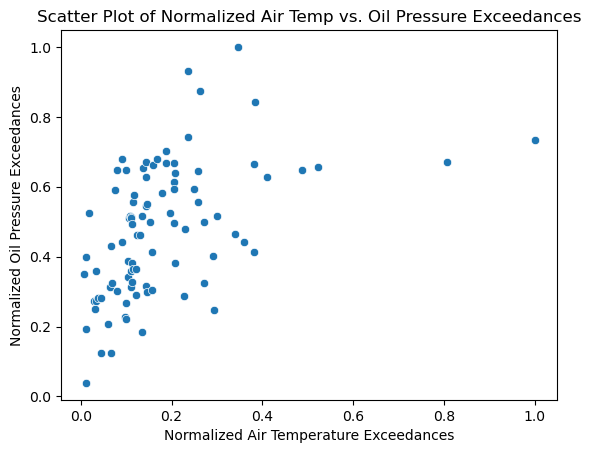

In [68]:
# Adjusting the normalization and merging process to include all vehicle IDs, filling missing occurrences with zero

# Normalizing the occurrence counts in each dataframe
df_air['occurrence_count_normalized'] = df_air['occurrence_count'] / df_air['occurrence_count'].max()
df_oil['occurrence_count_normalized'] = df_oil['occurrence_count'] / df_oil['occurrence_count'].max()
df_water['occurrence_count_normalized'] = df_water['occurrence_count'] / df_water['occurrence_count'].max()

# Merging the normalized dataframes on 'mapped_veh_id' and filling missing values with zero
merged_df = df_air.merge(df_oil, on='mapped_veh_id', suffixes=('_air', '_oil'), how='outer').fillna(0)

# Now, calculate the Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(merged_df['occurrence_count_normalized_air'], merged_df['occurrence_count_normalized_oil'])

# Print the correlation coefficient
print(f'Pearson correlation coefficient: {correlation_coefficient}')

# Plot the scatter plot
sns.scatterplot(data=merged_df, x='occurrence_count_normalized_air', y='occurrence_count_normalized_oil')
plt.title('Scatter Plot of Normalized Air Temp vs. Oil Pressure Exceedances')
plt.xlabel('Normalized Air Temperature Exceedances')
plt.ylabel('Normalized Oil Pressure Exceedances')
plt.show()

We see a moderate positive relation between Air anomalies and Oil anomalies. 

What can we investigate further? 

- How long do the temperatures rise outside of the boundaries?
- Is there a causal relationship between Air - Oil? 

We start by investigating the first question


In [77]:
# Define the query with placeholders for parameters
query_air = f"""
SELECT mapped_veh_id, rs_e_inairtemp_pc1, rs_e_inairtemp_pc2, timestamps_utc
FROM vehicle_data
WHERE rs_e_inairtemp_pc1 > 65 OR rs_e_inairtemp_pc2 > 65
ORDER BY mapped_veh_id, timestamps_utc;
"""

In [78]:
# Define the query with placeholders for parameters
query_oil = f"""
SELECT mapped_veh_id, rs_e_oilpress_pc1, rs_e_oilpress_pc2, timestamps_utc
FROM vehicle_data
WHERE rs_e_oilpress_pc1 > 115 OR rs_e_oilpress_pc2 > 115
ORDER BY mapped_veh_id, timestamps_utc;
"""

In [110]:
# Execute the query and fetch the data into a DataFrame
df_air = pd.read_sql_query(query_air, engine)
#df_oil = pd.read_sql_query(query_oil, engine)

In [105]:
df_air

,mapped_veh_id,rs_e_inairtemp_pc1,rs_e_inairtemp_pc2,timestamps_utc
0,102,33.0,66.0,2023-03-13 11:58:09
1,102,33.0,66.0,2023-03-13 11:58:15
2,102,33.0,66.0,2023-03-13 11:59:09
3,102,33.0,66.0,2023-03-13 11:59:17
4,102,33.0,67.0,2023-03-13 12:00:08
...,...,...,...,...
78441,197,66.0,61.0,2023-08-04 17:00:45
78442,197,66.0,64.0,2023-08-06 22:17:49
78443,197,66.0,64.0,2023-08-06 22:18:30
78444,197,66.0,64.0,2023-08-06 22:19:29


<Axes: title={'center': 'Daily Oil Pressure Exceedances'}, xlabel='date'>

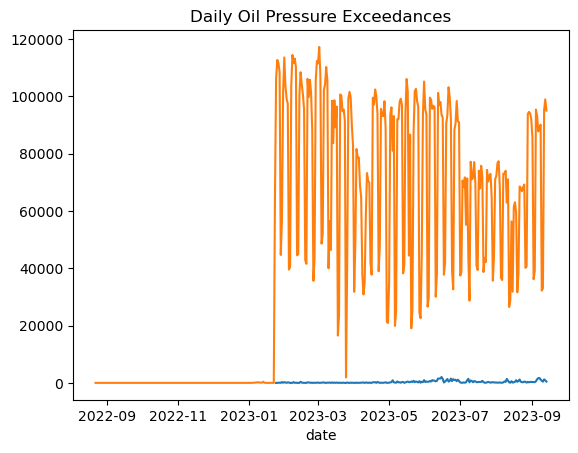

In [119]:
# Analyze how occurrences evolve over time by counting the number of exceedances per day
df_air['date'] = df_air['timestamps_utc'].dt.date
df_oil['date'] = df_oil['timestamps_utc'].dt.date

daily_exceedances_air = df_air.groupby('date').size()
daily_exceedances_oil = df_oil.groupby('date').size()

# Plotting the daily number of exceedances for both air and oil
daily_exceedances_air.plot(title='Daily Air Temperature Exceedances')
daily_exceedances_oil.plot(title='Daily Oil Pressure Exceedances')

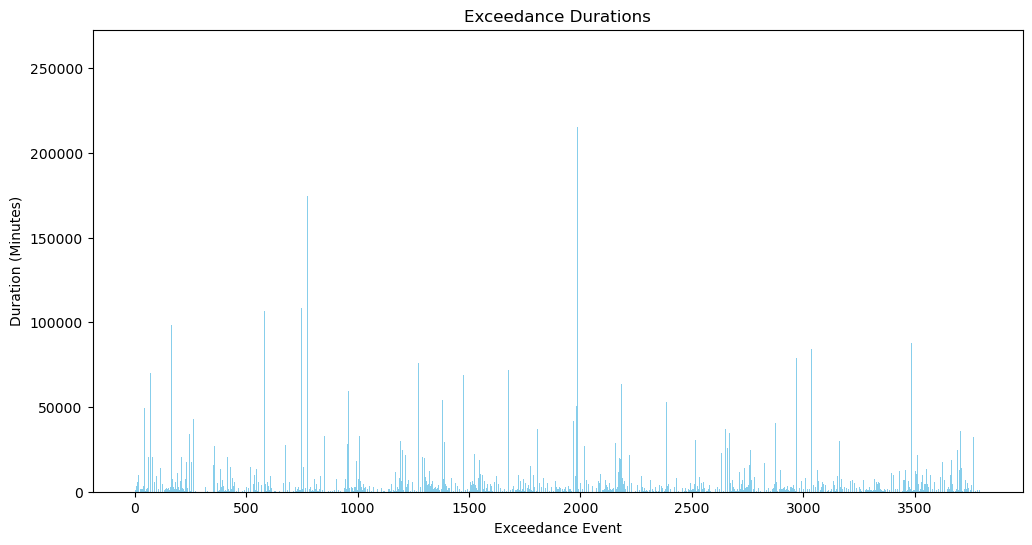

In [87]:
# Plot the durations of each exceedance period
# For plotting, let's remove the NaN values and reset the index
plot_data = df_air.dropna(subset=['exceedance_duration']).reset_index(drop=True)
plt.figure(figsize=(12, 6))
plt.bar(plot_data.index, plot_data['exceedance_duration'].dt.total_seconds() / 60, color='skyblue')  # Durations in minutes
plt.title('Exceedance Durations')
plt.xlabel('Exceedance Event')
plt.ylabel('Duration (Minutes)')
plt.show()